In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [8]:
#Descargar set de datos de MNIST (Numeros escritos a mano, etiquetados)
datos, metadatos = tfds.load('emnist', as_supervised=True, with_info=True)

In [9]:
#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

#Etiquetas de las 10 categorias posibles (simplemente son los numeros del 0 al 9)
nombres_clases = metadatos.features['label'].names

In [23]:
metadatos

tfds.core.DatasetInfo(
    name='emnist',
    version=3.0.0,
    description='The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.',
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62),
    }),
    total_num_examples=814255,
    splits={
        'test': 116323,
        'train': 697932,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{cohen_afshar_tapson_schaik_2017,
        title={EMNIST: Extending MNIST to handwritten lett

In [10]:
#Funcion de normalizacion para los datos (Pasar valor de los pixeles de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  #imagenes = tf.transpose(imagenes)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

In [11]:
#Crear el modelo
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dense(62, activation=tf.nn.softmax) #Para redes de clasificacion
])

#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [12]:
#Los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 128

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)
print(num_ej_entrenamiento/TAMANO_LOTE)


import math

#Entrenar
historial = modelo.fit((datos_entrenamiento),
                       epochs=20,
                       steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

5452.59375
Epoch 1/20
5453/5453 [==============================] - 184s 11ms/step - loss: 0.7969 - accuracy: 0.7441
Epoch 2/20
5453/5453 [==============================] - 60s 11ms/step - loss: 0.5726 - accuracy: 0.8044
Epoch 3/20
5453/5453 [==============================] - 61s 11ms/step - loss: 0.5322 - accuracy: 0.8167
Epoch 4/20
5453/5453 [==============================] - 60s 11ms/step - loss: 0.5147 - accuracy: 0.8211
Epoch 5/20
5453/5453 [==============================] - 59s 11ms/step - loss: 0.5021 - accuracy: 0.8255
Epoch 6/20
5453/5453 [==============================] - 60s 11ms/step - loss: 0.4953 - accuracy: 0.8266
Epoch 7/20
5453/5453 [==============================] - 60s 11ms/step - loss: 0.4877 - accuracy: 0.8288
Epoch 8/20
5453/5453 [==============================] - 60s 11ms/step - loss: 0.4855 - accuracy: 0.8304
Epoch 9/20
5453/5453 [==============================] - 60s 11ms/step - loss: 0.4805 - accuracy: 0.8320
Epoch 10/20
5453/5453 [=============================

In [13]:
modelo

In [14]:
#Exportar el modelo en formato h5
modelo.save('numerosyletras.h5')

In [ ]:
#El equipo es Linux. Listemos el contenido de la carpeta actual para ver que se exporto el modelo
#!ls

In [ ]:
#Para convertirlo a tensorflow.js, primero debemos instalar la libreria
#!pip install tensorflowjs

In [ ]:
#Crear carpeta donde se colocaran los archivos resultantes
#!mkdir carpeta_salida

In [ ]:
#Realizar la exportacion a la carpeta de salida
#!tensorflowjs_converter --input_format keras numeros.h5 carpeta_salida

In [ ]:
#Confirmar que en la carpeta de salida se hayan generado los archivos. Deben aparecer archivos "bin" y "json"
#!ls carpeta_salida

In [ ]:
#Para descargarlos, da clic del lado izquierdo en el icono de la carpeta
#y expande carpeta_salida. En los archivos utiliza los 3 puntos para descargarlos

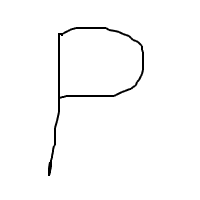

(1, 28, 28, 1)


In [58]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


img = cv2.imread('tuDibujo.png', 0)
cv2_imshow(img)
resized = cv2.resize(img, (28,28))
img_np = np.array(resized, dtype=np.float32)
img_np = np.reshape(img_np, (-1, 28, 28, 1))
img_np /= 255
img_np = np.absolute(img_np - 1)
img_np = img_np.T
cv2_imshow(resized)
print(img_np.shape)

In [ ]:
model = load_model('numerosyletras.h5')

In [59]:
pred_probab = modelo.predict(img_np)[0]
pred_class = list(pred_probab).index(max(pred_probab))
print(nombres_clases[pred_class])
print(pred_class)

45
45


In [60]:
import string
new_labels = list(range(10))+list(string.ascii_uppercase)+list(string.ascii_lowercase)

In [61]:
len(new_labels)

62

In [62]:
len(new_labels)

62

In [63]:
new_labels[pred_class]

'j'